In [1]:
!pip3 install pandas
!pip3 install pyspark
!pip3 install numpy
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install imblearn
!pip3 install torch


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
import pyspark as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('predictive_maintenance_dataset.csv')
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


# Initial Data Cleaning
1. Drop entries with NA/Null Values
2. Drop duplicates
3. Remove outliers

In [4]:
df.isna().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [5]:
print(df.shape[0])
df = df.drop_duplicates()
print(df.shape[0])

124494
124493


### Visualizing Outliers

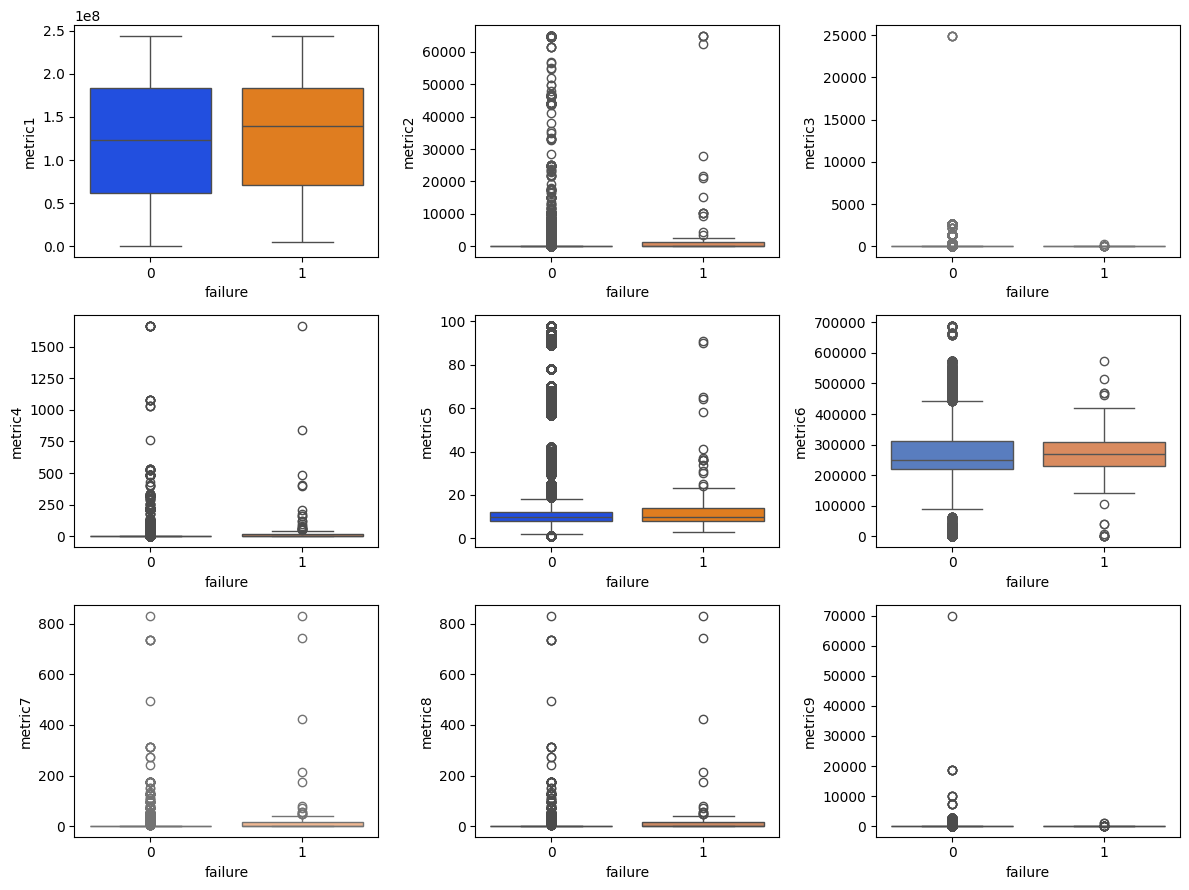

In [6]:
f, axes = plt.subplots(3,3, figsize = (12,9))

ax0 = sns.boxplot(x = "failure", y = "metric1", data= df, ax = axes[0,0], palette = "bright")

ax1 = sns.boxplot(x = "failure", y = "metric2", data= df, ax = axes[0,1], palette = "muted")

ax2 = sns.boxplot(x = "failure", y = "metric3", data= df, ax = axes[0,2], palette = "pastel")

ax3 = sns.boxplot(x = "failure", y = "metric4", data= df, ax = axes[1,0], palette = "deep")

ax4 = sns.boxplot(x = "failure", y = "metric5", data= df, ax = axes[1,1], palette = "bright")

ax5 = sns.boxplot(x = "failure", y = "metric6", data= df, ax = axes[1,2], palette = "muted")

ax6 = sns.boxplot(x = "failure", y = "metric7", data= df, ax = axes[2,0], palette = "pastel")

ax7 = sns.boxplot(x = "failure", y = "metric8", data= df, ax = axes[2,1], palette = "deep")

ax8 = sns.boxplot(x = "failure", y = "metric9", data= df, ax = axes[2,2], palette = "deep")
plt.tight_layout()

Metric2, 3, 4, 5, 7,8, and 9 are highly skewed to the right. We'll log them all to adjust for this.

There is definitely an outlier we can drop from the 0 group seen in metric3 and metric 9. Let's get rid of these.

Additionally, metric7 and metric8 look nearly identical. Let's take a deeper look into that.

In [7]:
print(df.shape[0])
df = df.loc[(df['metric3'] < 5000) & (df['metric9'] <= 20000)]
print(df.shape[0])

124493
124488


In [8]:
df['log_m2'] = np.log(df['metric2']+1)
df['log_m3'] = np.log(df['metric3']+1)
df['log_m4'] = np.log(df['metric4']+1)
df['log_m8'] = np.log(df['metric8']+1)
df['log_m9'] = np.log(df['metric9']+1)

In [9]:
df.nunique()

date          304
device       1168
failure         2
metric1    123872
metric2       560
metric3        47
metric4       114
metric5        60
metric6     44836
metric7        28
metric8        28
metric9        65
log_m2        560
log_m3         47
log_m4        114
log_m8         28
log_m9         65
dtype: int64

So despite there being 9 numerical columns, there aren't nearly as many unique values, which is interesting. Both metric7 and metric8 appear to have the same numer of unique values. This indicates that metric2, 3, 4, 5, 7,8, and 9 may in fact be categorical variables.

In [10]:
temp_df = df.metric7 == df.metric8

temp_df.value_counts()

True    124488
Name: count, dtype: int64

They're all the same, so we can remove one of these features without losing any information.

In [11]:
df.drop(columns=['metric7'], inplace = True)

In [12]:
#convert date column to correct datatype
df.date = pd.to_datetime(df.date)

# Initial Data Exploration

In [13]:
df.describe()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,log_m2,log_m3,log_m4,log_m8,log_m9
count,124488,124488.000000,1.244880e+05,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000,124488.000000
mean,2015-04-16 05:22:20.196645120,0.000851,1.223863e+08,159.487798,9.140367,1.724206,14.223114,260169.757752,0.292542,12.126454,0.318515,0.177487,0.162935,0.031562,0.395602
min,2015-01-01 00:00:00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-02-09 00:00:00,0.000000,6.128122e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-03-27 00:00:00,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249798.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015-06-17 00:00:00,0.000000,1.833057e+08,0.000000,0.000000,0.000000,12.000000,310262.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2015-11-02 00:00:00,1.000000,2.441405e+08,64968.000000,2693.000000,1666.000000,98.000000,689161.000000,832.000000,18701.000000,11.081666,7.898782,7.418781,6.725034,9.836386
std,NaN,0.029168,7.045859e+07,2179.729816,120.626692,22.713254,15.943271,99152.030376,7.437103,182.624525,1.446686,0.821468,0.646694,0.301833,1.004770


Metric1, 2, 3, 4, 8, and 9 all have standard deviations much larger than their means.

In [14]:
df.failure.value_counts()

failure
0    124382
1       106
Name: count, dtype: int64

Our labels are highly skewed in the direction of no failures. This may make generalization for a model difficult in the long run with such a small sample size.


Let's take a look at features that have the greatest separation between our labels.

In [15]:
grouped = df.groupby('failure')[["metric1", "metric2", "metric3", "metric4", "metric5", "metric6", "metric8", "metric9"]].mean()

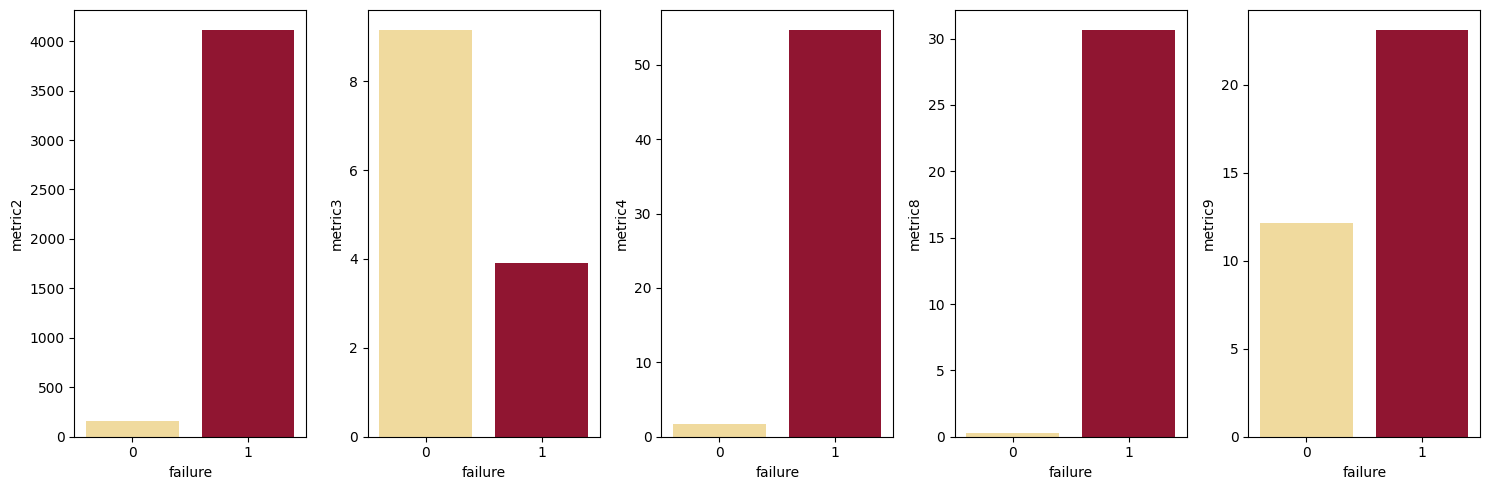

In [16]:
columns = ["metric2", "metric3", "metric4", "metric8", "metric9"]
palette = ["#fee090","#a50026"]
f,ax = plt.subplots(1, 5, figsize = (15,5))
i = 0
for col in columns:
    plt.subplot(1, 5, i+1)
    i += 1
    sns.barplot(grouped[col], palette = palette)
f.tight_layout()
plt.show()

The values for metric2, metric3, metric4, metric8, and metric9 are quite different for devices that have failed. They're all exceptionally higher aside from metric3.

Now, let's group our data by device and see what our data pool looks like

In [17]:
df.groupby('device').size().sort_values()

device
W1F1DA5ÿ      1
W1F0WJFT      3
S1F0CTDY      5
Z1F1473X      5
Z1F14F5V      5
           ... 
Z1F0GE1M    304
W1F0JY02    304
Z1F0QL3N    304
S1F0GPXY    304
Z1F0QK05    304
Length: 1168, dtype: int64

So the biggest sample size of a device is 304, with multiple occurences, ranging all the way down to devices that just have one instance. 

Now if we group devices by their category, maybe we can see if certain devices are more prone to failing than others.

In [18]:
df.groupby('device')["failure"].sum().sort_values()

device
S1F01085    0
W1F0X47W    0
W1F0X4AK    0
W1F0X4CX    0
W1F0X4F6    0
           ..
S1F0JGJV    1
Z1F0LVGY    1
S1F0JD7P    1
S1F0PJJW    1
W1F0TA59    1
Name: failure, Length: 1168, dtype: int64

Despite having 1,163 different kinds of devices in our dataset, with some devices having 300+ instances, not a single device type has more than 1 failure. It's hard to think that's a coincidence, and there's got to be some kind of explanation behind that. This kind of observation will prevent us from being able to make device-specific inferences because the sample size of failures will not be large enough for any one device. 

Now that we've seen that each device has at most 1 failure, with 106 total failures in our dataset, which means that about 9% of all devices have failed. 

It looks like devices fall into a patter of (Letter)(1)(Letter)(0) followed by 4 unique identifiers. Let's see if we can group our data by the first four symbols to see if a certain group is more likely to fail than others.

In [19]:
df['device_category'] = df.device.str[:4]
df.device_category.value_counts()

device_category
S1F0    33164
W1F0    23294
S1F1    21689
W1F1    19974
Z1F0    18868
Z1F1     7248
Z1F2      251
Name: count, dtype: int64

So it looks like there's three main precursor categories, S, W, and Z. The bars represent the amount of failures per device type, adjusted for the sample size of each respective device. 

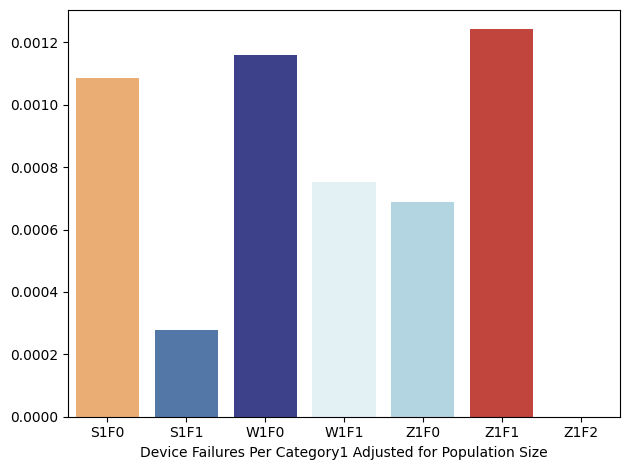

In [20]:

df.groupby('device_category').failure.sum() / df.groupby('device_category').count().device
palette = ["#fdae61", "#4575b4", "#313695", "#e0f3f8", "#abd9e9", "#d73027", "#313695"]
grouped_df = df.groupby('device_category').failure.sum() / df.groupby('device_category').count().device
sns.barplot(grouped_df, palette=palette).set(xlabel='Device Failures Per Category1 Adjusted for Population Size')


plt.tight_layout()

Here we can see with the first bar plot there are three category1 devices that have more failures than others relative to their population size, S1F0, W1F0. S1F1 and Z1F2 have very little to none, and W1F1 and Z1F0 are in between. 

Now let's take a look at date as it pertains to the devices, and do some feature engineering while we're at it.

In [21]:
print(df.date.min())
print(df.date.max())

2015-01-01 00:00:00
2015-11-02 00:00:00


Looks like the data is all from 2015. Let's engineer some new features to give us more descriptive date data

In [22]:
df['day']       = df['date'].dt.day
df['month']     = df['date'].dt.month
df['day_week']  = df['date'].dt.weekday
df['weekmonth'] = (df['day'] - 1) // 7 + 1

Let's take a look at the distribution of dates in our data, since we're looking at a time series. We'll group it by month.

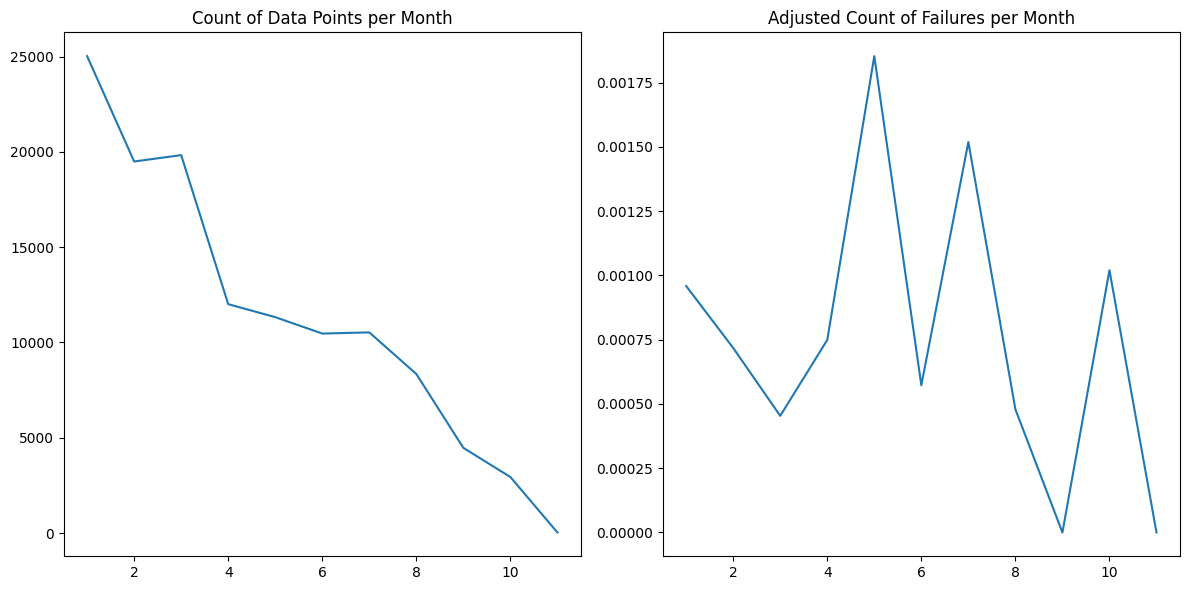

In [23]:
f,ax = plt.subplots(1, 2, figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(df.groupby('month').size())
plt.title("Count of Data Points per Month")

plt.subplot(1, 2, 2)
plt.plot(df.groupby("month")['failure'].sum() / df.groupby('month').size())
plt.title("Adjusted Count of Failures per Month")

f.tight_layout()

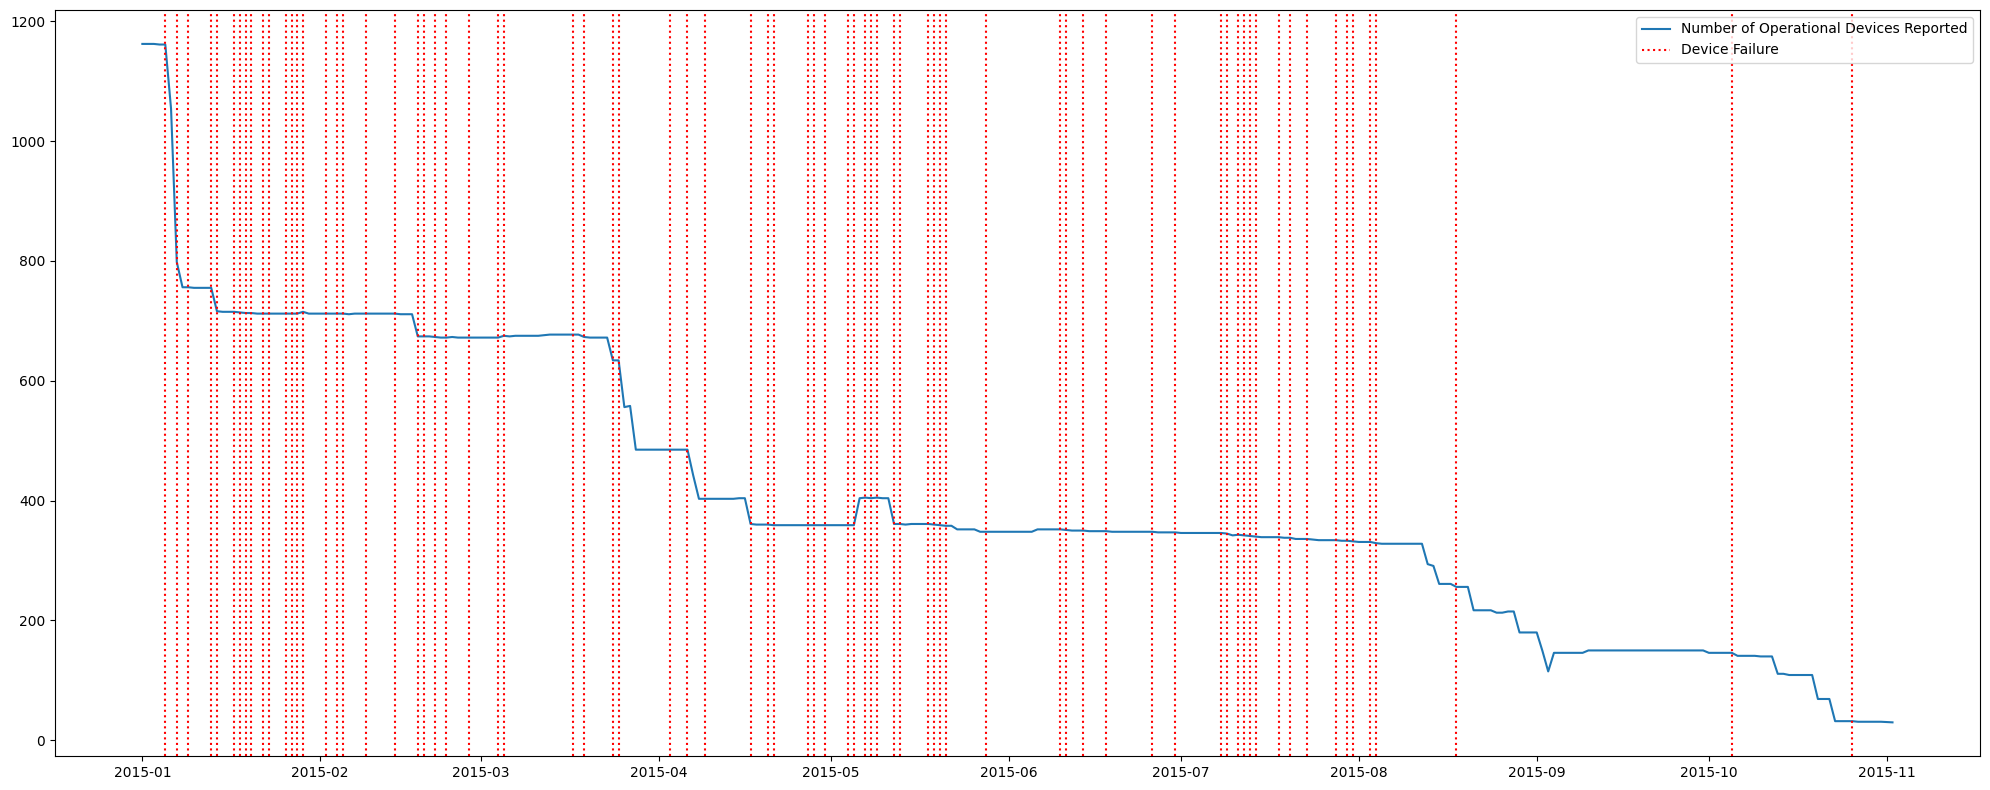

In [24]:
df_group = df.groupby('date').agg(working_devices = ('device','count'), failure = ('failure','max'))
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(df_group.index,df_group['working_devices'], label = 'Number of Operational Devices Reported')

idx = df_group[df_group['failure'] == 1].index
for i in range(len(idx)-2):
    plt.axvline(x =idx[i],linestyle =  'dotted', color = 'r')
    
plt.axvline(x = idx[-1], color = 'r',linestyle =':', label = 'Device Failure')
plt.legend(loc = 'upper right')
plt.tight_layout()

Amount of data that's recorded is decreasing pretty consistently over the year. There appears to spikes around months 1-3, 4-6, and 7-8. I wonder if devices are brought back up once they've failed

#### Check if a Device has Been Fixed
As we've seen, there are just over 1,100 unique devices, yet over 124,000 data entries. Which means that we have a lot of records of the same device over time. We can engineer a feature for the latest date recorded of a device. 

We can build from that to check if a device failed at some point, but at a later date is no longer recorded as failed. This would mean that the device was fixed at some point. 

In [25]:
df_date = df.groupby('device')['date'].max().reset_index()
df_date = df_date.rename(columns = {'date': 'lastRecordedDate'})
df = pd.merge(df, df_date, on = ['device'], how = 'left')

df.lastRecordedDate[:5]

0   2015-01-06
1   2015-01-06
2   2015-02-17
3   2015-01-06
4   2015-08-24
Name: lastRecordedDate, dtype: datetime64[ns]

In [26]:
#get deviceIDs that have failed and their current date is less than the date of their failure
eng_df = df[(df.failure==1)&(df.date != df.lastRecordedDate)]['device']

eng_df

77954     S1F136J0
79586     W1F0KCP2
79597     W1F0M35B
101994    S1F0GPFZ
104218    W1F11ZG9
Name: device, dtype: object

Only 5 devices have failed and then later been recorded as operational. Because of it being such a small sample, it's most likely not a very useful feature. However, it is interesting insight into the data nonetheless.

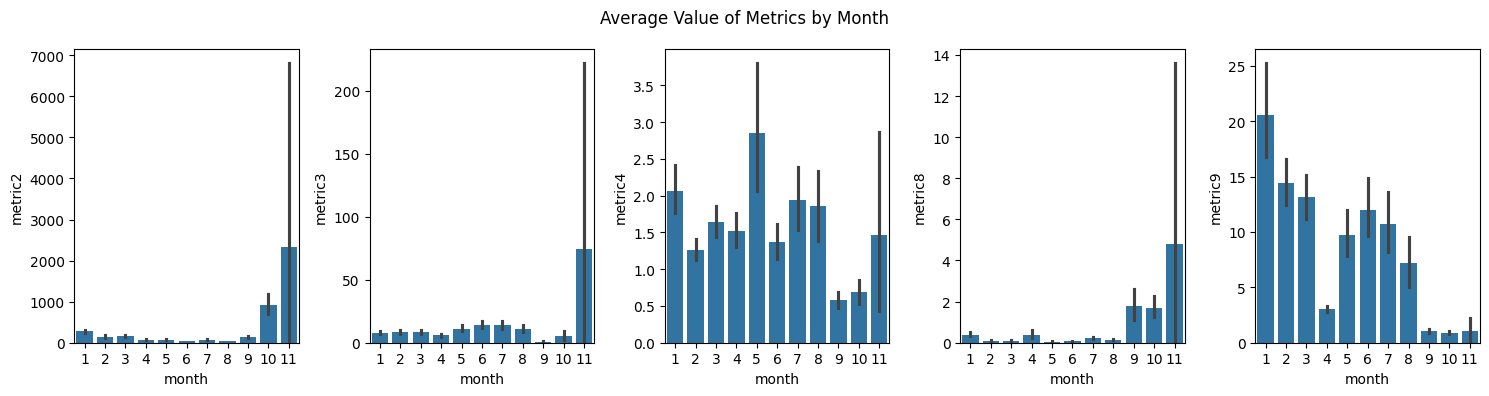

In [27]:
columns = ["metric2", "metric3", "metric4", "metric8", "metric9"]
f,ax = plt.subplots(1, 5, figsize = (15,4))
i = 0
for col in columns:
    plt.subplot(1, 5, i+1)
    i += 1
    sns.barplot(df, x = 'month', y = col)
    
plt.suptitle('Average Value of Metrics by Month')
f.tight_layout()
plt.show()


There's definitely something strange going on in the charts above. 

First, for metric2, metric3, metric7, and metric8, there's a pretty significant increase in these with respect to the last three months, and most notably the last month. and the increase isn't necessarily gradual either. This could be noise due to the fact that we need more data.

You would think that if these metrics were points of accumulation, you'd see an increase in them over time. However, that doesn't seem to be the case. The only metric that has a consistent trend is metric9, and it's in reverse as it gets smaller as the months pass by.

Additionally, it almost looks like the months can be grouped into 3 sets. 1-4, 5-8, and 9-11.

As we noted before, the amount of variability within these features is exceptionally low for them to be continuous. Most likely a lot of these are categorical data, so we should adjust accordingly.



### Label Encoding Categorical Variables
Previously we saw that although the metrics appear to be numerical continuous values, there aren't very many unique values for certain categories. 


In [28]:
df.nunique()

date                   304
device                1168
failure                  2
metric1             123872
metric2                560
metric3                 47
metric4                114
metric5                 60
metric6              44836
metric8                 28
metric9                 65
log_m2                 560
log_m3                  47
log_m4                 114
log_m8                  28
log_m9                  65
device_category          7
day                     31
month                   11
day_week                 7
weekmonth                5
lastRecordedDate       104
dtype: int64

Let's convert metric2, metric3, 4, 5, 7, 8, and 9 into categorical variables

In [29]:
from sklearn.preprocessing import LabelEncoder



In [30]:
df.dtypes

date                datetime64[ns]
device                      object
failure                      int64
metric1                      int64
metric2                      int64
metric3                      int64
metric4                      int64
metric5                      int64
metric6                      int64
metric8                      int64
metric9                      int64
log_m2                     float64
log_m3                     float64
log_m4                     float64
log_m8                     float64
log_m9                     float64
device_category             object
day                          int32
month                        int32
day_week                     int32
weekmonth                    int32
lastRecordedDate    datetime64[ns]
dtype: object

Let's try to visualize these metrics now so we can try and get a better idea of what's going on

# Examining features that give the best separation


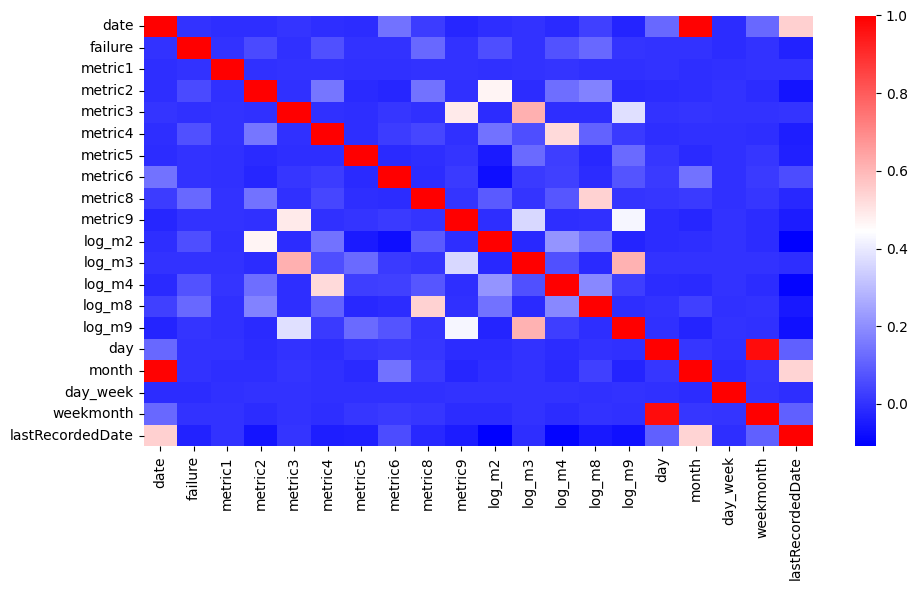

In [31]:
f = plt.figure(figsize = (10,6))
sub_df = df.drop(["device", "device_category"], axis = 1)
sub_df.head()
corr = sub_df.corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="bwr")
plt.tight_layout()

Some correlation between metric3 and metric9, as well as a very strong correlation between metric7 and metric8. This confirms our suspicions from earlier, and we can most likely drop either metric7 or metric8 without losing too much information. 

Additionally, there doesn't seem to be any difference in correlation between the logged metrics and original metrics. Thus, we'll drop the original metrics as smaller, logged metrics will make our model perform more effectively.

In [32]:
df.drop(["metric2", 'metric3', 'metric4', 'metric5', 'metric6', 'metric8', 'metric9', 'weekmonth'], axis = 1, inplace = True)

In [33]:
df.head()

,date,device,failure,metric1,log_m2,log_m3,log_m4,log_m8,log_m9,device_category,day,month,day_week,lastRecordedDate
0,2015-01-01,S1F01085,0,215630672,4.025352,0.000000,3.970292,0.0,2.079442,S1F0,1,1,3,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0.000000,1.386294,0.000000,0.0,0.000000,S1F0,1,1,3,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0.000000,0.000000,0.000000,0.0,0.000000,S1F0,1,1,3,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0.000000,0.000000,0.000000,0.0,0.000000,S1F0,1,1,3,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0.000000,0.000000,0.000000,0.0,1.386294,S1F0,1,1,3,2015-08-24


# Machine Learning Prototype


We'll start off with a simple model like logistic regression. This is interpretable and explainable, so it should be a solid baseline to get an understanding before we move onto more complicated models.

Because there is a major class imbalance of mostly samples that have not failed, we will implement stratified k-fold cross validation. This ensures that each fold maintains the same proportion of observations for each target class as the complete dataset.

Additionally, because we saw earlier that some metrics have very high means and standard deviations, we will normalize these metrics. This will allow for the model to predict more accurately by not incorrectly weighing features more simply because they have potentially extreme values. 

Finally, as mentioned earlier, there is a strong class imbalance. In order to correct this, we will oversample. This makes it so that there are an equal number of failures as non failures in the training data. This is done by random sampling from the failure data until there an equal number of data points of both classes.

Note, that since we are applying K-fold cross validation, it is important to apply the oversampling after we split the data with cross validation. If we do it before, i.e. oversample, then do k-fold cross validation, there will potentially be data leakage. This is because oversampling takes data that already exists and duplicates it. So there will be duplicate rows, thus potentially having one instance be in the training data, and one in the test data, which will lead to overfitting. 



In [34]:
nonNumericColumns = ["device", "date", "lastRecordedDate"]

engineered_df = df.drop(nonNumericColumns, axis = 1)

X,y = engineered_df.drop(columns = ["failure"]), engineered_df.failure

print(X.shape)
X.head()

(124488, 10)


,metric1,log_m2,log_m3,log_m4,log_m8,log_m9,device_category,day,month,day_week
0,215630672,4.025352,0.000000,3.970292,0.0,2.079442,S1F0,1,1,3
1,61370680,0.000000,1.386294,0.000000,0.0,0.000000,S1F0,1,1,3
2,173295968,0.000000,0.000000,0.000000,0.0,0.000000,S1F0,1,1,3
3,79694024,0.000000,0.000000,0.000000,0.0,0.000000,S1F0,1,1,3
4,135970480,0.000000,0.000000,0.000000,0.0,1.386294,S1F0,1,1,3


In [35]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: int64

Below we're going to create a class specifically for the columns of our feature (X) matrix. We need to normalize metric1 of the data because it is so large, but not other metrics as they are ordinal categorical features. 

You may be wondering, why don't we just normalize that column right now, before we split the data into train and test? We don't do that because that will cause data leakage, i.e. the test data normalization for metric1 will have included our train data, which will skew our results and potentially lead to incorrect accuracy metrics.

In [36]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

numeric = ['metric1']
categorical = ['log_m2', 'log_m3', 'log_m4', 'log_m8', 'log_m9', 'day', 'month', 'day_week']

In [37]:
def preprocess(X,y,OHE,low_card,scaler,i,sm):
    samples = X.copy()
    labels = y.copy()
    
    samples.reset_index(inplace = True, drop = True)
    labels.reset_index(inplace = True, drop = True)
    
    if i == 1:
        #Encoding categorical variables for train set
        coding_hot = OHE.fit_transform(samples[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns = OHE.get_feature_names_out(low_card))
        samples = pd.concat([samples, aux], axis=1).drop(low_card, axis=1)
        # Scaling as features
        aux = scaler.fit_transform(samples)
        samples = pd.DataFrame(aux,index= samples.index, columns= samples.columns)
        xf, yf = sm.fit_resample(samples, labels) 
        
    else:
        #Encoding categorical variables for test set
        coding_hot = OHE.transform(samples[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns = OHE.get_feature_names_out(low_card))
        samples = pd.concat([samples, aux], axis=1).drop(low_card, axis=1)
        # Scaling as features
        aux2 = scaler.transform(samples)
        xf = pd.DataFrame(aux2,index=samples.index, columns=samples.columns)
        yf = y
    
    return xf, yf


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

X_train.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

X_test.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)


In [39]:
X_train.head()

,metric1,log_m2,log_m3,log_m4,log_m8,log_m9,device_category,day,month,day_week
0,210331464,0.0,0.000000,0.0,0.0,0.000000,W1F1,10,1,5
1,241893544,0.0,0.000000,0.0,0.0,0.000000,W1F0,19,7,6
2,159871712,0.0,5.398163,0.0,0.0,3.218876,S1F0,16,1,4
3,243540872,0.0,0.000000,0.0,0.0,0.000000,W1F1,31,5,6
4,58172424,0.0,0.000000,0.0,0.0,0.000000,Z1F0,4,1,6


In [40]:
X_train.describe()

,metric1,log_m2,log_m3,log_m4,log_m8,log_m9,day,month,day_week
count,8.714100e+04,87141.000000,87141.000000,87141.000000,87141.000000,87141.000000,87141.000000,87141.000000,87141.000000
mean,1.225075e+08,0.319076,0.177434,0.164197,0.031064,0.396357,14.905831,4.027702,3.009938
std,7.050994e+07,1.445548,0.822763,0.651295,0.299585,1.005679,8.750221,2.569862,1.999602
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,6.138375e+07,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,1.000000
50%,1.227866e+08,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,3.000000,3.000000
75%,1.836940e+08,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,6.000000,5.000000
max,2.441405e+08,11.081666,7.898782,7.418781,6.725034,9.836386,31.000000,11.000000,6.000000


In [41]:
X_train.nunique()

metric1            86783
log_m2               487
log_m3                45
log_m4               104
log_m8                26
log_m9                64
device_category        7
day                   31
month                 11
day_week               7
dtype: int64

In [42]:
print(X_train.columns)
print(X_train.shape)
print(X_train.dtypes)

Index(['metric1', 'log_m2', 'log_m3', 'log_m4', 'log_m8', 'log_m9',
       'device_category', 'day', 'month', 'day_week'],
      dtype='object')
(87141, 10)
metric1              int64
log_m2             float64
log_m3             float64
log_m4             float64
log_m8             float64
log_m9             float64
device_category     object
day                  int32
month                int32
day_week             int32
dtype: object


In [43]:
from sklearn.compose import ColumnTransformer
columns_to_encode = ['device_category']
columns_to_scale  = ['metric1']

OHE =  OneHotEncoder(handle_unknown = 'ignore',sparse_output=False)

scaler = StandardScaler()

#Oversampler to help with class imbalance
sm = SMOTE(random_state=0)

#First drop any non numeric categories
pipeline=ColumnTransformer([
    ('num',scaler,columns_to_scale),
    ('cat',OHE,columns_to_encode),
    
])

new_X_train= pipeline.fit_transform(X_train)
new_X_test = pipeline.transform(X_test)

In [44]:
ohe_columns = pipeline.get_feature_names_out()
X_train_encoded = pd.DataFrame(new_X_train, index = X_train.index, columns=ohe_columns)
X_test_encoded =  pd.DataFrame(new_X_test, index = X_test.index, columns=ohe_columns)

X_train.drop(columns=["device_category", "metric1"], inplace=True)
X_test.drop(columns=["device_category", "metric1"], inplace=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train.head()

,log_m2,log_m3,log_m4,log_m8,log_m9,day,month,day_week,num__metric1,cat__device_category_S1F0,cat__device_category_S1F1,cat__device_category_W1F0,cat__device_category_W1F1,cat__device_category_Z1F0,cat__device_category_Z1F1,cat__device_category_Z1F2
0,0.0,0.000000,0.0,0.0,0.000000,10,1,5,1.245562,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,19,7,6,1.693190,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,5.398163,0.0,0.0,3.218876,16,1,4,0.529917,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,31,5,6,1.716553,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,4,1,6,-0.912431,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
print(y_train.value_counts())

failure
0    87072
1    87072
Name: count, dtype: int64


In [46]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(174144, 16) (174144,)
(37347, 16) (37347,)
